In [41]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

## Stat data

In [42]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [43]:
stat_list_org = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files]

In [44]:
stat_list_org[0].columns[stat_list_org[0].isna().sum(0) > 0]

Index(['bezrobocie_zarejsestrowane_gminy', 'ludnosc_na_1km2',
       'dochody_na_mieszkanca', 'wyksztalcenie_wyzsze',
       'udzial_wiek_przedprodukcyjny', 'udzial_wiek_produkcyjny',
       'udzial_wiek_poprodukcyjny', 'socjal_500plus', 'przestepstwa_ogolem'],
      dtype='object')

In [45]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [46]:
stat_list_minmax = stat_list_org.copy()
stat_list_mean = stat_list_org.copy()

In [47]:
#MINMAX scaling
for st in range(len(stat_list_org)):
    stat_list_minmax[st] = stat_list_org[st][col_not_na0 & col_not_na17]
    # min max normalization
    stat_list_minmax[st] = (stat_list_minmax[st]-stat_list_minmax[st].min(0)) / (stat_list_minmax[st].max(0)-stat_list_minmax[st].min(0))

In [48]:
for st in range(len(stat_list_org)):
    stat_list_mean[st] = stat_list_org[st][col_not_na0 & col_not_na17]
    # nrmalization mean (around 0)
    stat_list_mean[st] = (stat_list_mean[st]-stat_list_mean[st].mean(0)) / (stat_list_mean[st].std(0))

In [49]:
stat_list = stat_list_mean if (True) else stat_list_minmax

## Percent voting people

In [50]:
voter_w = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

## Poll data

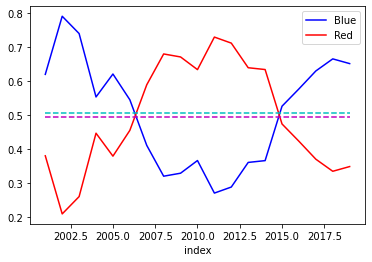

In [51]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/no_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [52]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [53]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [54]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [55]:
vote_list[0] = vote_list[0].set_index('województwo')

## Neighbours

In [56]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Use 2 approaches to estimate date from years without elections

In [57]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [58]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]

In [59]:
pool_d = par_in_reg_list if (False) else reg_in_par_list 

## Examining stat data

In [60]:
len(stat_list)

18

In [61]:
len(stat_list_org)

18

In [62]:
len(pool_d[:-1])

18

In [63]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_m = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_mean, pool_d[1:])]
pool_stat_mm = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_minmax, pool_d[1:])]

In [64]:
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)
pool_stat_df_m = pd.concat(pool_stat_m).reset_index(drop=True)
pool_stat_df_mm = pd.concat(pool_stat_mm).reset_index(drop=True)

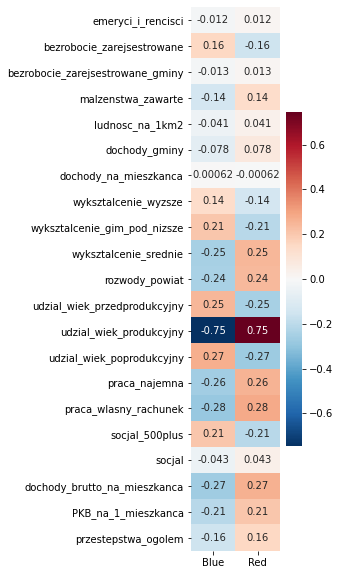

In [65]:
fig, ax = plt.subplots(figsize=(2,10))
sn.heatmap(pool_stat_df_org.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

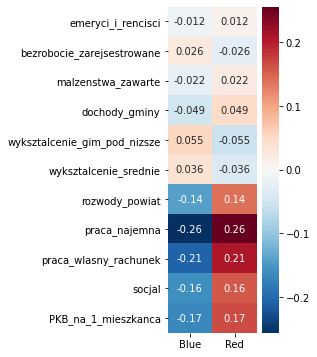

In [66]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_m.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

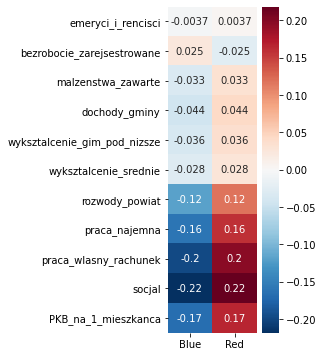

In [67]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_mm.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

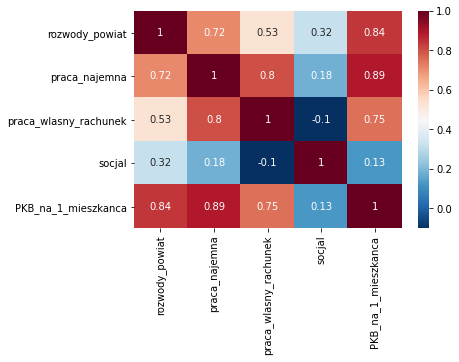

In [68]:
sn.heatmap(pool_stat_df_m.corr().iloc[6:-2,6:-2], annot=True, cmap='RdBu_r')
plt.show()

In [69]:
stat_list = [st.iloc[:,6:] for st in stat_list]

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [70]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(len(stat_list)):
    # iterate over districts
    tmp_x = []
    st_data = stat_list[y]
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(lo[0]/lo.sum())
        tmp_y.append(avg_n)
        tmp_y.append(pool_data_middle['Blue'].values[y])
                
        tmp_x.append(tmp_y)
    X.append(tmp_x)

In [71]:
X = np.array(X)
X.shape

(18, 16, 8)

## Prepare Y

In [72]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [73]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [74]:
X.shape

(18, 16, 8)

### Models with percentage of Blue support per district

In [75]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    OUTPUT:
    y - predicted value in (0,1)
    '''
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2 *
          np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) *
          x)
    return y1

### Setup for testing model

In [76]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [77]:
st_data.shape

(16, 5)

In [80]:
def prepare_input(y, st_data, pool=pool_data_middle, year=0):
    tmp_x = np.zeros((y.shape[0],st_data.shape[-1]+3))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(y[d,0])
        tmp_y.append(avg_n)
        tmp_y.append(pool['Blue'].values[year])
        
        tmp_x[d] = np.array(tmp_y)
    return(tmp_x)

In [81]:
def model(a,x,Y,st_list,pool=pool_data_middle):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        st_data = stat_list[year-1]
        xi = prepare_input(y,st_list[year-1])
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

In [82]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
#av = np.random.rand(X.shape[1],X.shape[2])

step = 0.01
beta = 0.1
a_avg.shape

(16, 8)

## Use output -> next input (grad each step)

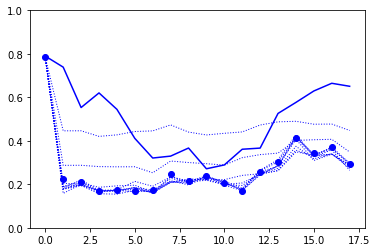

In [88]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 1

for epoch in range(10**2):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i],year=i)
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%10==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

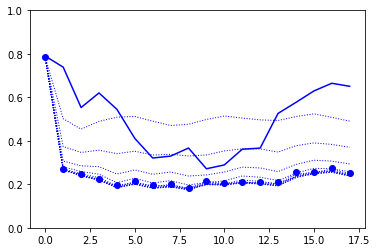

In [89]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.1

for epoch in range(10**2):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i],year=i)
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%10==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

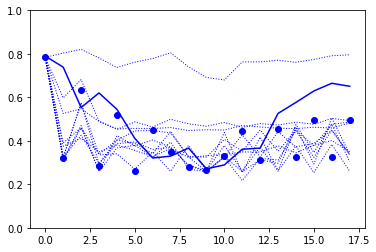

In [91]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 10

for epoch in range(10**2):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i],year=i)
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%10==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

## All at once + evolution strategies (TO DO)

# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
for epoch in range(10**3):
    grad = grad_percent(a_avg,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
a_avg.shape

[]

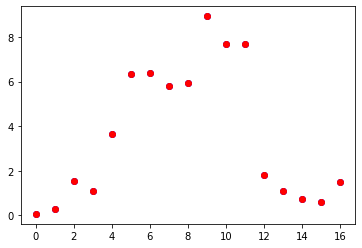

In [264]:
l_avg, o = model(a_avg,X,Y)
l_all, o = model(a_all,X,Y)
plt.plot(l_avg,'bo')
plt.plot(l_all,'ro')
plt.plot()

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI

In [56]:
(a_avg-a_all).max()

0.004963590920596506